In [ ]:
filenum = 29
expid = 1
import os
import numpy as np
import time
sleeptime = np.random.rand(1)*10
time.sleep(int(sleeptime*100)/100)
filehead = 'lstm_leaky_result_train_losses_imdb'+str(filenum).zfill(3)+'_'
jlist = [int(j.split(filehead)[1].split('.')[0]) for j in os.listdir('.') if j.startswith(filehead) and j.endswith('.log')]
if len(jlist)==0:
    expid = 1
else:
    expid = np.max(jlist)+1
import torch
torch.save(0,filehead + str(expid).zfill(3) + '.log')
# 'lstm_leaky_result_train_losses_imdb'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt'

In [2]:
expid

1

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(expid)
    torch.manual_seed(expid)
    print("GPU is available")
else:
    device = torch.device("cpu")
    torch.manual_seed(expid)
    print("GPU not available, CPU used")

GPU is available


In [5]:
base_csv = 'data/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, train_size = 0.1, test_size = 0.1)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (5000,)
shape of test data is (5000,)


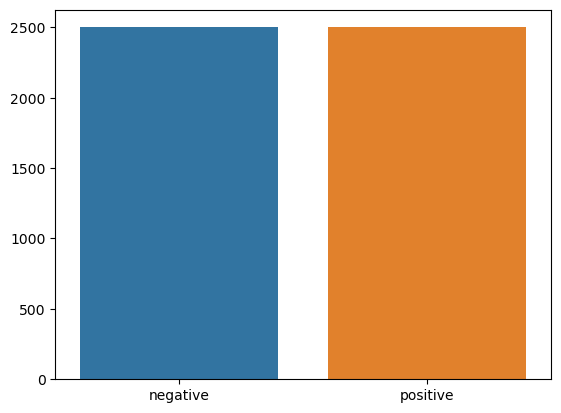

In [7]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [8]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [10]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

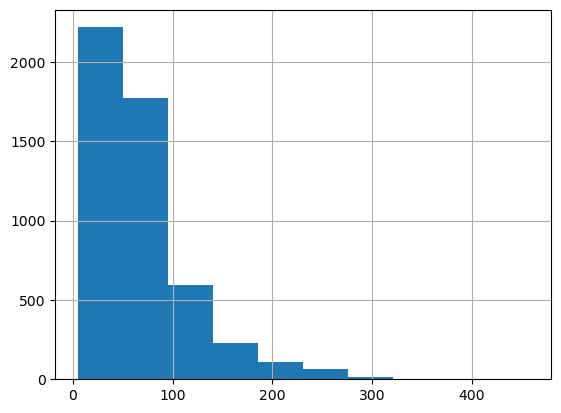

count    5000.000000
mean       69.701000
std        48.177678
min         5.000000
25%        39.000000
50%        54.000000
75%        85.000000
max       457.000000
dtype: float64

In [11]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

Now we will pad each of the sequence to max length 

In [12]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [13]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
print(x_train_pad.shape)
print(x_test_pad.shape)

(5000, 500)
(5000, 500)


In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 905,   6,  58],
        [  0,   0,   0,  ..., 546, 319,  32],
        [  0,   0,   0,  ..., 307, 600, 926],
        ...,
        [  0,   0,   0,  ..., 174, 657,  70],
        [  0,   0,   0,  ...,  61, 336, 524],
        [  0,   0,   0,  ...,  84, 616,   2]])
Sample input: 
 tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0])


In [16]:
len(valid_loader)

100

### Model

We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

In [17]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,hidden_dim2,embedding_dim,alpha,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.alpha = alpha
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
#         self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim2),
#             nn.GELU(),
            nn.LeakyReLU(negative_slope = self.alpha),
            nn.Linear(self.hidden_dim2, output_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#                 m.bias.data.zero_()
                nn.init.constant_(m.bias, 0)
                nn.init.normal_(m.weight, mean=0, std=np.sqrt(2./m.out_features))
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)/np.sqrt(self.alpha*self.alpha+1)
        
#         # sigmoid function
#         sig_out = self.sig(out)
        
#         # reshape to be batch_size first
#         sig_out = sig_out.view(batch_size, -1)
        out = out.view(batch_size, -1)

#         sig_out = sig_out[:, -1] # get last batch of labels
        out = out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [18]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
hidden_dim2 = 4096



### Training

In [ ]:
clip = 5
epochs = 300 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
train_losses_dict = dict()
val_losses_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()
alphalist = [-2,-1,0,0.01]

torch.manual_seed(expid)

# loss and optimization functions
lr=1e-5

criterion = nn.BCEWithLogitsLoss()

# function to predict accuracy
def acc(pred,label):
    m = nn.Sigmoid()
    pred = m(pred)
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

# start training for different leaky relu alphas
for alpha in alphalist:
    model = SentimentRNN(no_layers,vocab_size,hidden_dim,hidden_dim2,embedding_dim,alpha = alpha,drop_prob=0.5)
    
    #moving to gpu
    model.to(device)

    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    for epoch in range(epochs):
        print(epoch)
        train_losses = []
        train_acc = 0.0
        model.train()
        # initialize hidden state 
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)   
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
#             h = tuple([each.data for each in h])
            h = model.init_hidden(batch_size)
            h = tuple([each.data for each in h])

            model.zero_grad()
            output,h = model(inputs,h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.lstm.parameters(), clip)
            optimizer.step()


        print(epoch)
        val_h = model.init_hidden(batch_size)
        val_losses = []
        val_acc = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_loader:
    #                 val_h = tuple([each.data for each in val_h])
    #                 print(val_h)
                    val_h = model.init_hidden(batch_size)
                    val_h = tuple([each.data for each in val_h])

                    inputs, labels = inputs.to(device), labels.to(device)

                    output, val_h = model(inputs, val_h)
                    print(output)
                    print(labels)
                    val_loss = criterion(output.squeeze(), labels.float())
                    print(val_loss)

                    val_losses.append(val_loss.item())

                    accuracy = acc(output,labels)
                    val_acc += accuracy
        print(epoch)
        print(val_losses)
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'save_imdb/state_dict'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'alpha_'+str(alpha)+'.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')
    train_losses_dict[alpha] = epoch_tr_loss
    val_losses_dict[alpha] = epoch_vl_loss
    train_acc_dict[alpha] = epoch_tr_acc
    val_acc_dict[alpha] = epoch_vl_acc
    torch.save(train_losses_dict, 'lstm_leaky_result_train_losses_imdb'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')
    torch.save(val_losses_dict, 'lstm_leaky_result_val_losses_imdb'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')
    torch.save(train_acc_dict, 'lstm_leaky_result_train_acc_imdb'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')
    torch.save(val_acc_dict, 'lstm_leaky_result_val_acc_imdb'+str(filenum).zfill(3)+'_'+str(expid).zfill(3)+'.pt')
